<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-ensembling-gradientboosting-with-lags-02?scriptVersionId=258919246" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

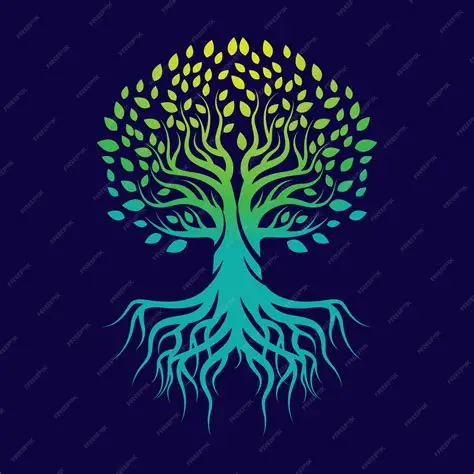

---

**In this notebook, we will use Ensembling Gradient Boosting trees for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run Ensembling Gradient Boosting trees with lags targets
* How to build an optimized prediction function for API inference



---

In [1]:
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
trainl = trainl.fillna(0)

In [3]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [4]:
Features = [i for i in trainl.columns ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features[1:]:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [5]:
_,train_lagged = creat_lagged_labels(trainl)

In [6]:
train_lagged

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.000000,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,1912,-0.001049,0.010689,-0.013043,-0.003886,0.016628,0.002027,0.000903,0.013468,0.006847,...,-0.029812,0.013292,-0.044024,-0.002339,0.023029,0.035976,-0.056517,0.017393,0.006221,0.007932
1913,1913,-0.012596,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,...,0.046582,0.025419,-0.030993,0.038743,0.026417,0.030334,0.029837,0.002042,0.032667,-0.015732
1914,1914,-0.000736,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,...,0.028187,0.017681,-0.024106,0.051672,0.005058,0.027760,0.017625,0.004573,0.047833,-0.024001
1915,1915,-0.002294,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,...,0.022579,-0.005401,-0.029530,0.059486,-0.002650,0.014873,0.010885,-0.011085,0.052410,-0.127879


In [7]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [8]:
Features2 = Features + ["target_id"]
X_train = training_df[Features2]
y_train = training_df["target"]

In [9]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
# Deeper Gradient Boosting models for regression
xgb_model = XGBRegressor(
    n_estimators=2000,       # more boosting rounds
    max_depth=6,            # deeper trees
    learning_rate=0.01,      # smaller LR for stability
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    tree_method="hist",
    device="cuda"            # remove if no GPU
)
warnings.filterwarnings("ignore")
lgbm_model = LGBMRegressor(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.01,
    num_leaves=256,          # more leaves for depth
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    device="gpu"  ,           # remove if no GPU
    verbose=-1
)

catboost_model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.01,
    l2_leaf_reg=3,
    #subsample=0.8,
    random_seed=42,
    loss_function='RMSE',
    task_type="GPU",         # remove if no GPU
    verbose=False
)

# Append models to a list for later training / ensembling
models = [xgb_model, lgbm_model, catboost_model]
Models = []
# Example usage: training all models
for model in models:
     model.fit(X_train, y_train)
     Models.append(model)
    

print(f"Models list created with {len(models)} models.")


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Models list created with 3 models.


In [10]:
def ensemble_predict(models, X):
    """
    Predict using a list of trained models and return the averaged prediction.
    
    Parameters:
        models : list of trained models
        X      : numpy array or DataFrame of features
        
    Returns:
        ensemble_pred : averaged prediction across models
    """
    preds = [model.predict(X) for model in models]
    ensemble_pred = np.mean(preds, axis=0)
    return ensemble_pred

In [11]:
#ensemble_predict(Models, X_train)

In [12]:
X_data = X_train.copy()
X_data["preds"] = ensemble_predict(Models, X_train)

In [13]:
X_train[Features2]

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423,target_id
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812803,1912,-0.001049,0.010689,-0.013043,-0.003886,0.016628,0.002027,0.000903,0.013468,0.006847,...,0.013292,-0.044024,-0.002339,0.023029,0.035976,-0.056517,0.017393,0.006221,0.007932,423
812804,1913,-0.012596,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,...,0.025419,-0.030993,0.038743,0.026417,0.030334,0.029837,0.002042,0.032667,-0.015732,423
812805,1914,-0.000736,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,...,0.017681,-0.024106,0.051672,0.005058,0.027760,0.017625,0.004573,0.047833,-0.024001,423
812806,1915,-0.002294,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,...,-0.005401,-0.029530,0.059486,-0.002650,0.014873,0.010885,-0.011085,0.052410,-0.127879,423


In [14]:
X_data

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423,target_id,preds
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.000130
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.000150
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000165
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000071
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310,0,-0.000332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812803,1912,-0.001049,0.010689,-0.013043,-0.003886,0.016628,0.002027,0.000903,0.013468,0.006847,...,-0.044024,-0.002339,0.023029,0.035976,-0.056517,0.017393,0.006221,0.007932,423,0.000214
812804,1913,-0.012596,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,...,-0.030993,0.038743,0.026417,0.030334,0.029837,0.002042,0.032667,-0.015732,423,-0.008573
812805,1914,-0.000736,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,...,-0.024106,0.051672,0.005058,0.027760,0.017625,0.004573,0.047833,-0.024001,423,-0.008315
812806,1915,-0.002294,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,...,-0.029530,0.059486,-0.002650,0.014873,0.010885,-0.011085,0.052410,-0.127879,423,-0.000081


In [15]:
ensemble_predict(Models, X_train[Features2])

array([-1.29691612e-04, -1.49978797e-04,  1.64913556e-04, ...,
       -8.31459386e-03, -8.12915960e-05,  1.04438335e-04])

In [16]:
X_data[["target_id","preds"]]

,target_id,preds
0,0,-0.000130
1,0,-0.000150
2,0,0.000165
3,0,0.000071
4,0,-0.000332
...,...,...
812803,423,0.000214
812804,423,-0.008573
812805,423,-0.008315
812806,423,-0.000081


In [17]:
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide
# Done: df_wide has shape (90, 424)

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-0.000130,-0.000130,-0.000130,-0.000130,-0.000130,-0.000134,-0.000134,-0.000134,-0.000134,-0.000073,...,0.000294,0.000224,0.000103,0.000118,0.000104,0.000108,0.000358,0.000492,0.000616,0.000285
1,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000154,-0.000154,-0.000154,-0.000154,-0.000103,...,0.000259,0.000176,0.000048,0.000066,0.000057,0.000057,0.000342,0.000481,0.000656,0.000450
2,0.000165,0.000165,0.000165,0.000165,0.000165,0.000160,0.000160,0.000134,0.000134,0.000113,...,-0.000431,-0.000573,-0.000610,-0.000628,-0.000782,-0.000778,-0.000588,-0.000441,-0.000178,-0.000209
3,0.000071,0.000071,0.000071,0.000071,0.000071,0.000060,0.000060,0.000045,0.000045,0.000092,...,0.000229,0.000098,-0.000060,-0.000075,-0.000172,-0.000172,-0.000041,0.000121,0.000693,0.000537
4,-0.000332,-0.000332,-0.000332,-0.000335,-0.000335,-0.000350,-0.000350,-0.000365,-0.000365,-0.000327,...,-0.000367,-0.000377,-0.000753,-0.000752,-0.000678,-0.000674,-0.000616,-0.000657,0.000088,-0.000310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,-0.000336,-0.000336,-0.000338,-0.000342,-0.000346,-0.000346,-0.000346,-0.000359,-0.000359,-0.000187,...,0.000865,0.000553,0.000449,0.000497,0.000530,0.000562,0.000851,0.001041,0.000833,0.000214
1913,-0.000111,-0.000111,-0.000111,-0.000111,-0.000111,-0.000109,-0.000109,-0.000123,-0.000123,-0.000175,...,-0.001806,-0.002253,-0.003340,-0.003588,-0.003536,-0.003561,-0.003742,-0.003967,-0.006428,-0.008573
1914,-0.001031,-0.001031,-0.001031,-0.001031,-0.001031,-0.001027,-0.001027,-0.001034,-0.001034,-0.001063,...,-0.002291,-0.002642,-0.003178,-0.004040,-0.004346,-0.004382,-0.004665,-0.004965,-0.006301,-0.008315
1915,-0.000268,-0.000268,-0.000268,-0.000272,-0.000272,-0.000272,-0.000272,-0.000275,-0.000275,-0.000247,...,0.000320,0.000008,-0.000207,-0.000392,-0.000688,-0.000701,-0.000187,-0.000215,0.000125,-0.000081


In [18]:
#https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [19]:
score(trainl[Features[1:]],df_wide[Features[1:]])

1.5201191260718177

In [20]:
ycols = ['target_' + str(i) for i in range(424)]

In [21]:
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features[1:]].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred[Features[0]].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features[1:])},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))

    preds = ensemble_predict(Models, X_pred2[Features2].to_pandas())
    X_pred2 = X_pred2.with_columns(pl.Series("preds", preds))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [22]:
# submission through the API

inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [23]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,-0.000172,-0.000172,-0.000172,-0.000172,-0.000172,-0.000176,-0.000176,-0.000176,-0.000176,-0.000115,-0.000102,-0.000084,-0.000084,-0.000084,-0.000081,-0.000146,-0.000146,-0.000156,-0.000157,-0.000157,-0.000157,-0.000165,-0.00018,-0.00018,-0.000181,-0.000175,-0.000175,-0.000139,-0.000139,-0.000144,-0.000204,-0.000204,-0.000204,-0.00019,-0.000186,-0.000186,…,-0.000363,-0.000386,-0.000367,-0.000439,-0.000738,-0.000769,-0.00072,-0.00075,-0.000797,-0.000853,-0.000717,-0.000825,-0.000981,-0.000926,-0.000923,-0.000804,-0.001198,0.000859,-0.000083,-0.000084,-0.000083,0.000048,-7.8268e-7,-0.000053,0.000175,0.000714,0.000069,0.000248,0.000179,0.000053,0.000069,0.000077,0.000077,0.000344,0.000474,0.000614,0.000084
1828,-0.000172,-0.000172,-0.000172,-0.000172,-0.000172,-0.000176,-0.000176,-0.000176,-0.000176,-0.000115,-0.000102,-0.000084,-0.000084,-0.000084,-0.000081,-0.000146,-0.000146,-0.000156,-0.000157,-0.000157,-0.000157,-0.000165,-0.00018,-0.00018,-0.000181,-0.000175,-0.000175,-0.000139,-0.000139,-0.000144,-0.000204,-0.000204,-0.000204,-0.00019,-0.000186,-0.000186,…,-0.000363,-0.000386,-0.000367,-0.000439,-0.000738,-0.000769,-0.00072,-0.00075,-0.000797,-0.000853,-0.000717,-0.000825,-0.000981,-0.000926,-0.000923,-0.000804,-0.001198,0.000859,-0.000083,-0.000084,-0.000083,0.000048,-7.8268e-7,-0.000053,0.000175,0.000714,0.000069,0.000248,0.000179,0.000053,0.000069,0.000077,0.000077,0.000344,0.000474,0.000614,0.000084
1829,-0.00022,-0.00022,-0.00022,-0.00022,-0.00022,-0.000217,-0.000217,-0.000217,-0.000217,-0.000155,-0.000143,-0.000124,-0.000124,-0.000124,-0.000122,-0.00018,-0.00018,-0.000191,-0.000191,-0.000191,-0.000191,-0.000196,-0.000213,-0.000213,-0.000213,-0.000208,-0.000208,-0.000167,-0.000167,-0.000172,-0.000237,-0.000237,-0.000237,-0.000224,-0.000219,-0.000219,…,-0.000455,-0.000483,-0.000464,-0.000536,-0.000837,-0.000868,-0.000819,-0.00085,-0.000895,-0.000952,-0.000815,-0.000911,-0.001067,-0.001012,-0.001009,-0.000882,-0.001288,0.000787,-0.000152,-0.000148,-0.000147,-0.000019,-0.000068,-0.00012,0.000107,0.000657,0.000025,0.000225,0.000151,0.000019,0.000037,0.000027,0.000027,0.000247,0.000372,0.000477,-0.000053
1830,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000082,-0.000082,-0.000101,-0.000101,-0.000104,-0.00009,-0.000093,-0.000093,-0.000093,-0.00009,-0.000091,-0.000091,-0.000096,-0.000096,-0.000096,-0.00009,-0.000082,-0.000106,-0.000106,-0.000106,-0.00008,-0.00008,-0.000047,-0.000047,-0.000026,-0.000084,-0.000083,-0.000083,-0.000069,-0.000065,-0.000065,…,-0.000272,-0.000298,-0.000268,-0.000237,-0.000494,-0.000501,-0.000306,-0.000501,-0.000568,-0.000595,-0.000472,-0.000498,-0.00053,-0.000475,-0.000472,-0.000328,-0.000902,0.001116,0.000173,0.000184,0.000185,0.000274,0.000234,0.000224,0.000529,0.001011,0.000303,0.000565,0.000406,0.000164,0.000187,0.000364,0.000364,0.000603,0.000672,0.000829,0.000452
1831,0.000191,0.000191,0.000191,0.000191,0.000191,0.000185,0.000185,0.000